In [1]:
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
import torch
from torchvision import transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import os
import segmentation_models_pytorch as smp
import torch
import torch.nn as nn
from torchvision import models
from torch.nn.functional import relu


/home/devbox/miniconda3/envs/iris/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
class SegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.image_files = sorted(os.listdir(images_dir))
        self.mask_files = sorted(os.listdir(masks_dir))
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Загружаем изображения и маски
        image_path = os.path.join(self.images_dir, self.image_files[idx])
        mask_path = os.path.join(self.masks_dir, self.mask_files[idx])

        image = Image.open(image_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')

        # Применение преобразований
        if self.transform:
            image = self.transform(image)

        # Преобразуем маску в тензор и убираем лишнюю размерность
        mask = transforms.ToTensor()(mask)  
        mask = mask.unsqueeze(0)

        return image, mask

In [4]:
image_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

])

In [5]:
# Пути к папкам с изображениями и масками
images_dir = 'Forest_Segmented/Forest Segmented/images'
masks_dir = 'Forest_Segmented/Forest Segmented/masks'

# Получаем список файлов
image_files = sorted(os.listdir(images_dir))
mask_files = sorted(os.listdir(masks_dir))


train_images, valid_images, train_masks, valid_masks = train_test_split(
    image_files, mask_files, test_size=0.2, random_state=42
)

# Создание датасетов
train_dataset = SegmentationDataset(
    images_dir=images_dir,
    masks_dir=masks_dir,
    transform=image_transform
)

valid_dataset = SegmentationDataset(
    images_dir=images_dir,
    masks_dir=masks_dir,
    transform=image_transform
)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Valid dataset size: {len(valid_dataset)}")

Train dataset size: 5108
Valid dataset size: 5108


In [6]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)

In [7]:
# Загрузка предобученной модели U-Net
#model = smp.Unet(
    #encoder_name='resnet50',        # Энкодер
    #encoder_weights='imagenet',    # Предобученные веса на ImageNet
    #in_channels=3,                 # Количество входных каналов (RGB = 3)
#     classes=1                      # Количество классов (для бинарной сегментации = 1)
# )
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model.to(device)

class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()

        # Encoder
        # In the encoder, convolutional layers with the Conv2d function are used to extract features from the input image. 
        # Each block in the encoder consists of two convolutional layers followed by a max-pooling layer, with the exception of the last block which does not include a max-pooling layer.
        # -------
        # input: 572x572x3
        self.e11 = nn.Conv2d(3, 64, kernel_size=3, padding=1) # output: 570x570x64
        self.e12 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # output: 568x568x64
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 284x284x64

        # input: 284x284x64
        self.e21 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # output: 282x282x128
        self.e22 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # output: 280x280x128
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 140x140x128

        # input: 140x140x128
        self.e31 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # output: 138x138x256
        self.e32 = nn.Conv2d(256, 256, kernel_size=3, padding=1) # output: 136x136x256
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 68x68x256

        # input: 68x68x256
        self.e41 = nn.Conv2d(256, 512, kernel_size=3, padding=1) # output: 66x66x512
        self.e42 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output: 64x64x512
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 32x32x512

        # input: 32x32x512
        self.e51 = nn.Conv2d(512, 1024, kernel_size=3, padding=1) # output: 30x30x1024
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1) # output: 28x28x1024

        # Decoder
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.d11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.d12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.d22 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.d42 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        # Output layer
        self.outconv = nn.Conv2d(64, n_class, kernel_size=1)

    def forward(self, x):
        # Encoder
        xe11 = relu(self.e11(x))
        xe12 = relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = relu(self.e21(xp1))
        xe22 = relu(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = relu(self.e31(xp2))
        xe32 = relu(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = relu(self.e41(xp3))
        xe42 = relu(self.e42(xe41))
        xp4 = self.pool4(xe42)

        xe51 = relu(self.e51(xp4))
        xe52 = relu(self.e52(xe51))

        # Decoder
        xu1 = self.upconv1(xe52)
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = relu(self.d11(xu11))
        xd12 = relu(self.d12(xd11))

        xu2 = self.upconv2(xd12)
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = relu(self.d21(xu22))
        xd22 = relu(self.d22(xd21))

        xu3 = self.upconv3(xd22)
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = relu(self.d31(xu33))
        xd32 = relu(self.d32(xd31))

        xu4 = self.upconv4(xd32)
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = relu(self.d41(xu44))
        xd42 = relu(self.d42(xd41))

        # Output layer
        out = self.outconv(xd42)

        return out

In [8]:
model=UNet(1)

In [9]:
import torch.nn as nn
import torch.optim as optim

In [10]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, nesterov=True )

In [11]:
import numpy as np

# Функция для вычисления IoU
def calculate_iou(true_mask, pred_mask):
    intersection = np.sum(true_mask * pred_mask)
    union = np.sum(true_mask) + np.sum(pred_mask) - intersection
    return intersection / union if union != 0 else 0

# Функция для вычисления Dice Coefficient
def calculate_dice(true_mask, pred_mask):
    intersection = np.sum(true_mask * pred_mask)
    return (2.0 * intersection) / (np.sum(true_mask) + np.sum(pred_mask) + 1e-7)

# Функция для вычисления Accuracy
def calculate_accuracy(true_mask, pred_mask):
    correct_pixels = np.sum(true_mask == pred_mask)
    total_pixels = true_mask.size
    return correct_pixels / total_pixels

In [12]:
def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_iou = 0.0
        train_dice = 0.0
        train_accuracy = 0.0

        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)

            outputs = outputs.unsqueeze(1)

            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            preds = torch.sigmoid(outputs).detach().cpu().numpy() > 0.5
            true_masks = masks.detach().cpu().numpy()

            train_iou += np.mean([calculate_iou(true_mask, pred_mask)
                                  for true_mask, pred_mask in zip(true_masks, preds)])
            train_dice += np.mean([calculate_dice(true_mask, pred_mask)
                                   for true_mask, pred_mask in zip(true_masks, preds)])
            train_accuracy += np.mean([calculate_accuracy(true_mask, pred_mask)
                                       for true_mask, pred_mask in zip(true_masks, preds)])

        # Валидация
        model.eval()
        valid_loss = 0.0
        valid_iou = 0.0
        valid_dice = 0.0
        valid_accuracy = 0.0
        with torch.no_grad():
            for images, masks in valid_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)

                outputs = outputs.unsqueeze(1)  # Добавляем размерность канала
                loss = criterion(outputs, masks)
                valid_loss += loss.item()

                preds = torch.sigmoid(outputs).detach().cpu().numpy() > 0.5
                true_masks = masks.detach().cpu().numpy()

                valid_iou += np.mean([calculate_iou(true_mask, pred_mask)
                                      for true_mask, pred_mask in zip(true_masks, preds)])
                valid_dice += np.mean([calculate_dice(true_mask, pred_mask)
                                       for true_mask, pred_mask in zip(true_masks, preds)])
                valid_accuracy += np.mean([calculate_accuracy(true_mask, pred_mask)
                                           for true_mask, pred_mask in zip(true_masks, preds)])

        train_loss /= len(train_loader)
        train_iou /= len(train_loader)
        train_dice /= len(train_loader)
        train_accuracy /= len(train_loader)

        valid_loss /= len(valid_loader)
        valid_iou /= len(valid_loader)
        valid_dice /= len(valid_loader)
        valid_accuracy /= len(valid_loader)

        print(f"Epoch {epoch + 1}/{num_epochs}, "
              f"Train Loss: {train_loss:.4f}, Train IoU: {train_iou:.4f}, Train Dice: {train_dice:.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Valid Loss: {valid_loss:.4f}, Valid IoU: {valid_iou:.4f}, Valid Dice: {valid_dice:.4f}, Valid Accuracy: {valid_accuracy:.4f}")

In [13]:
model = model.to(device)

In [93]:
#train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=50)

Epoch 1/50, Train Loss: 0.6247, Train IoU: 0.5750, Train Dice: 0.6608, Train Accuracy: 0.6397, Valid Loss: 0.5999, Valid IoU: 0.5946, Valid Dice: 0.6906, Valid Accuracy: 0.7009
Epoch 2/50, Train Loss: 0.5961, Train IoU: 0.5865, Train Dice: 0.6841, Train Accuracy: 0.7045, Valid Loss: 0.5913, Valid IoU: 0.5813, Valid Dice: 0.6799, Valid Accuracy: 0.7065
Epoch 3/50, Train Loss: 0.5901, Train IoU: 0.5788, Train Dice: 0.6776, Train Accuracy: 0.7063, Valid Loss: 0.5890, Valid IoU: 0.5838, Valid Dice: 0.6819, Valid Accuracy: 0.7064
Epoch 4/50, Train Loss: 0.5880, Train IoU: 0.5777, Train Dice: 0.6768, Train Accuracy: 0.7068, Valid Loss: 0.5851, Valid IoU: 0.5815, Valid Dice: 0.6798, Valid Accuracy: 0.7073
Epoch 5/50, Train Loss: 0.5850, Train IoU: 0.5795, Train Dice: 0.6780, Train Accuracy: 0.7076, Valid Loss: 0.5830, Valid IoU: 0.5861, Valid Dice: 0.6836, Valid Accuracy: 0.7077
Epoch 6/50, Train Loss: 0.5824, Train IoU: 0.5810, Train Dice: 0.6793, Train Accuracy: 0.7080, Valid Loss: 0.5830, 

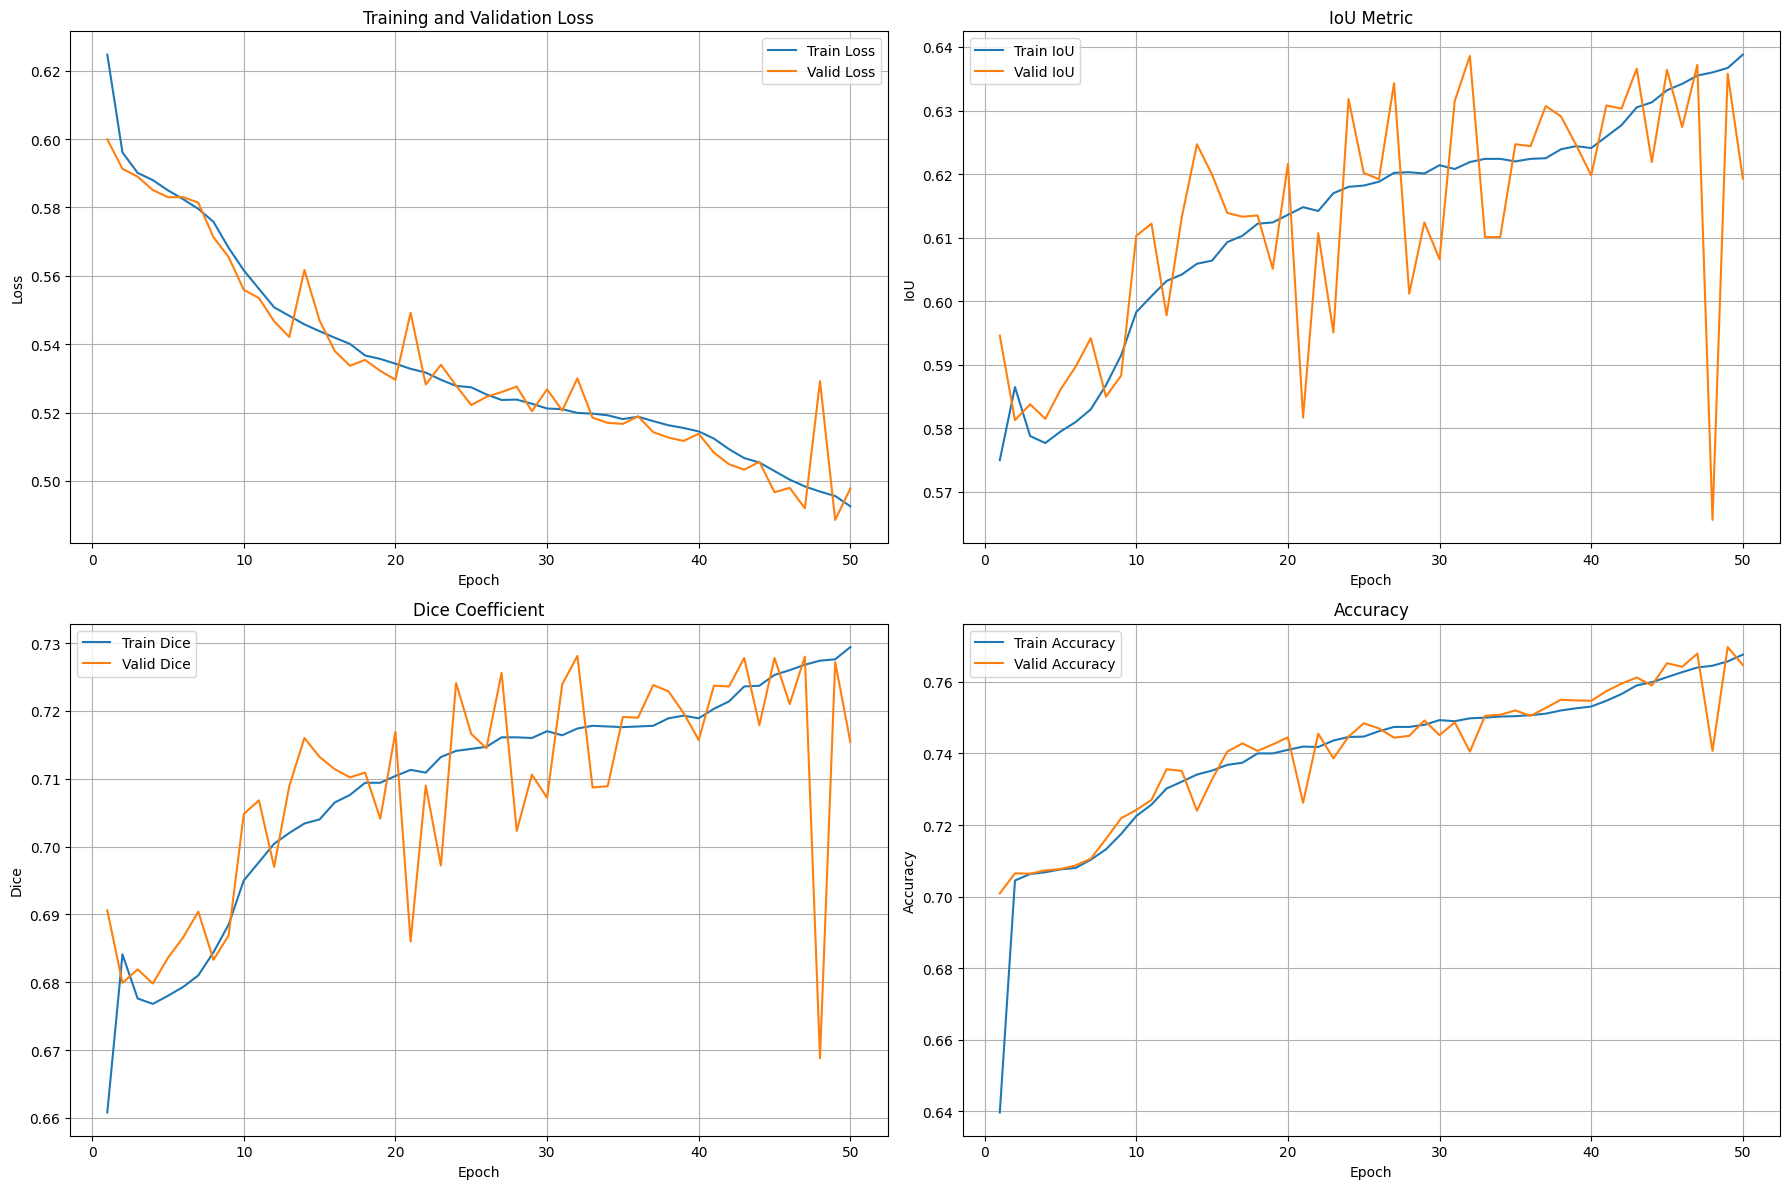

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Данные из вашего лога обучения
epochs = np.arange(1, 51)
train_loss = [0.6247, 0.5961, 0.5901, 0.5880, 0.5850, 0.5824, 0.5796, 0.5758, 
              0.5682, 0.5616, 0.5562, 0.5508, 0.5483, 0.5458, 0.5438, 0.5419, 
              0.5401, 0.5367, 0.5357, 0.5343, 0.5328, 0.5317, 0.5296, 0.5278, 
              0.5274, 0.5253, 0.5237, 0.5238, 0.5226, 0.5212, 0.5210, 0.5199, 
              0.5197, 0.5192, 0.5181, 0.5188, 0.5175, 0.5163, 0.5155, 0.5145, 
              0.5124, 0.5093, 0.5067, 0.5054, 0.5029, 0.5004, 0.4984, 0.4969, 
              0.4956, 0.4926]

valid_loss = [0.5999, 0.5913, 0.5890, 0.5851, 0.5830, 0.5830, 0.5814, 0.5713, 
              0.5655, 0.5559, 0.5535, 0.5467, 0.5421, 0.5617, 0.5469, 0.5380, 
              0.5337, 0.5354, 0.5322, 0.5296, 0.5492, 0.5282, 0.5340, 0.5279, 
              0.5222, 0.5246, 0.5260, 0.5276, 0.5204, 0.5268, 0.5206, 0.5300, 
              0.5185, 0.5170, 0.5167, 0.5189, 0.5143, 0.5127, 0.5117, 0.5138, 
              0.5083, 0.5049, 0.5033, 0.5056, 0.4967, 0.4980, 0.4920, 0.5292, 
              0.4886, 0.4978]

# Создаем 4 графика
plt.figure(figsize=(18, 12))

# График Loss
plt.subplot(2, 2, 1)
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, valid_loss, label='Valid Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# График IoU
plt.subplot(2, 2, 2)
plt.plot(epochs, [0.5750, 0.5865, 0.5788, 0.5777, 0.5795, 0.5810, 0.5830, 0.5868,
                 0.5915, 0.5983, 0.6008, 0.6032, 0.6042, 0.6059, 0.6064, 0.6093,
                 0.6103, 0.6122, 0.6124, 0.6136, 0.6148, 0.6142, 0.6170, 0.6180,
                 0.6182, 0.6188, 0.6202, 0.6203, 0.6201, 0.6214, 0.6208, 0.6219,
                 0.6224, 0.6224, 0.6220, 0.6224, 0.6225, 0.6239, 0.6244, 0.6241,
                 0.6259, 0.6277, 0.6305, 0.6313, 0.6332, 0.6342, 0.6355, 0.6360,
                 0.6367, 0.6388], label='Train IoU')
plt.plot(epochs, [0.5946, 0.5813, 0.5838, 0.5815, 0.5861, 0.5897, 0.5942, 0.5850,
                 0.5883, 0.6103, 0.6122, 0.5978, 0.6132, 0.6247, 0.6199, 0.6139,
                 0.6133, 0.6135, 0.6051, 0.6216, 0.5817, 0.6107, 0.5951, 0.6318,
                 0.6202, 0.6192, 0.6343, 0.6012, 0.6124, 0.6066, 0.6315, 0.6386,
                 0.6101, 0.6101, 0.6247, 0.6244, 0.6307, 0.6291, 0.6246, 0.6198,
                 0.6308, 0.6303, 0.6366, 0.6219, 0.6364, 0.6274, 0.6372, 0.5656,
                 0.6358, 0.6193], label='Valid IoU')
plt.title('IoU Metric')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()
plt.grid(True)

# График Dice
plt.subplot(2, 2, 3)
plt.plot(epochs, [0.6608, 0.6841, 0.6776, 0.6768, 0.6780, 0.6793, 0.6810, 0.6844,
                 0.6885, 0.6950, 0.6977, 0.7004, 0.7020, 0.7034, 0.7040, 0.7065,
                 0.7076, 0.7094, 0.7094, 0.7104, 0.7113, 0.7109, 0.7132, 0.7141,
                 0.7144, 0.7147, 0.7161, 0.7161, 0.7160, 0.7170, 0.7164, 0.7174,
                 0.7178, 0.7177, 0.7176, 0.7177, 0.7178, 0.7189, 0.7193, 0.7189,
                 0.7203, 0.7214, 0.7236, 0.7237, 0.7253, 0.7260, 0.7268, 0.7274,
                 0.7276, 0.7294], label='Train Dice')
plt.plot(epochs, [0.6906, 0.6799, 0.6819, 0.6798, 0.6836, 0.6866, 0.6904, 0.6833,
                 0.6869, 0.7048, 0.7068, 0.6970, 0.7089, 0.7160, 0.7132, 0.7114,
                 0.7102, 0.7109, 0.7041, 0.7169, 0.6860, 0.7090, 0.6972, 0.7241,
                 0.7166, 0.7145, 0.7256, 0.7023, 0.7106, 0.7072, 0.7239, 0.7281,
                 0.7087, 0.7089, 0.7191, 0.7190, 0.7238, 0.7229, 0.7197, 0.7157,
                 0.7237, 0.7236, 0.7278, 0.7179, 0.7278, 0.7210, 0.7280, 0.6688,
                 0.7272, 0.7154], label='Valid Dice')
plt.title('Dice Coefficient')
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.legend()
plt.grid(True)

# График Accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, [0.6397, 0.7045, 0.7063, 0.7068, 0.7076, 0.7080, 0.7103, 0.7132,
                 0.7175, 0.7225, 0.7257, 0.7302, 0.7321, 0.7341, 0.7352, 0.7368,
                 0.7374, 0.7400, 0.7400, 0.7410, 0.7419, 0.7418, 0.7436, 0.7446,
                 0.7447, 0.7462, 0.7474, 0.7474, 0.7480, 0.7493, 0.7490, 0.7498,
                 0.7500, 0.7503, 0.7504, 0.7507, 0.7511, 0.7520, 0.7526, 0.7531,
                 0.7547, 0.7566, 0.7590, 0.7599, 0.7613, 0.7627, 0.7640, 0.7645,
                 0.7657, 0.7676], label='Train Accuracy')
plt.plot(epochs, [0.7009, 0.7065, 0.7064, 0.7073, 0.7077, 0.7087, 0.7106, 0.7161,
                 0.7219, 0.7242, 0.7270, 0.7356, 0.7351, 0.7240, 0.7328, 0.7405,
                 0.7428, 0.7407, 0.7425, 0.7445, 0.7262, 0.7455, 0.7386, 0.7447,
                 0.7484, 0.7470, 0.7444, 0.7449, 0.7492, 0.7451, 0.7487, 0.7405,
                 0.7505, 0.7508, 0.7520, 0.7505, 0.7527, 0.7550, 0.7548, 0.7547,
                 0.7574, 0.7595, 0.7612, 0.7590, 0.7652, 0.7642, 0.7679, 0.7407,
                 0.7697, 0.7647], label='Valid Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [29]:
plt.savefig('metrics_plot.png', dpi=300, bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

In [94]:
#torch.save(model, 'second_model.pt')

In [30]:
image_path = 'Forest_Segmented/Forest Segmented/images/855_sat_41.jpg'
mask_path = 'Forest_Segmented/Forest Segmented/masks/855_mask_41.jpg'

# Загрузка и предобработка изображения
image = Image.open(image_path).convert("RGB")
image_tensor = transform(image).unsqueeze(0).to(device)

# Загрузка истинной маски
true_mask = Image.open(mask_path).convert("L")  # Конвертация в оттенки серого
true_mask = np.array(true_mask.resize((256, 256))) / 255  # Изменение размера и нормализация [0, 1]

# Инференс
model.eval()
with torch.no_grad():
    output = model(image_tensor)
    pred_mask = torch.sigmoid(output).cpu().numpy()[0][0] > 0.5  # Бинаризация предсказания

plt.figure(figsize=(18, 6))

# Исходное изображение
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Input Image")
plt.axis("off")

# Истинная маска
plt.subplot(1, 3, 2)
plt.imshow(true_mask, cmap="gray")
plt.title("Ground Truth Mask")
plt.axis("off")

# Предсказанная маска
plt.subplot(1, 3, 3)
plt.imshow(pred_mask, cmap="gray")
plt.title("Predicted Mask")
plt.axis("off")

plt.show()

NameError: name 'transform' is not defined

In [31]:
import requests
from io import BytesIO
from PIL import Image
import torch
import numpy as np
import matplotlib.pyplot as plt

# Укажите URL изображения (можно заменить на любой другой)
image_url = "https://resizer.mail.ru/p/dfb962cc-e4bc-5826-ba42-989916b35bbe/AQAKeh8ciCESEYx045mJrc5Oq4eR45INQND5E_7Y0X3UlEOjqDng3JKP9FQFE9mk7JDFlTV9aElRAyeHz2xsN3cIaJ8.jpg"  # Замените на реальный URL

# Загрузка изображения из интернета
response = requests.get(image_url)
image = Image.open(BytesIO(response.content)).convert("RGB")

# Преобразование изображения для модели
image_tensor = transform(image).unsqueeze(0).to(device)

# Предсказание маски
model.eval()
with torch.no_grad():
    output = model(image_tensor)
    pred_mask = torch.sigmoid(output).cpu().numpy()[0][0] > 0.5  # Бинаризация

# Визуализация (только исходное изображение и предсказание)
plt.figure(figsize=(12, 6))

# Исходное изображение
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Input Image")
plt.axis("off")

# Предсказанная маска
plt.subplot(1, 2, 2)
plt.imshow(pred_mask, cmap="gray")
plt.title("Predicted Mask")
plt.axis("off")

plt.show()

NameError: name 'transform' is not defined